In [1]:
import yfinance as yf
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
from datetime import datetime

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Fetch Sanofi Stock Data for 2023

In [2]:
# Define the ticker symbol for Sanofi
ticker = "SNY"

# Fetch the data
sanofi_data = yf.download(ticker, start="2022-12-01", end="2023-12-31")

# Calculate daily returns in percentage
sanofi_data['DailyReturn'] = sanofi_data['Close'].pct_change() * 100

# Check the calculated daily returns
sanofi_data[['Close', 'DailyReturn']].head()

[*********************100%%**********************]  1 of 1 completed


,Close,DailyReturn
Date,,
2022-12-01,45.869999,NaN
2022-12-02,45.009998,-1.874865
2022-12-05,44.930000,-0.177734
2022-12-06,48.549999,8.056975
2022-12-07,47.939999,-1.256438


In [3]:
sanofi_data

,Open,High,Low,Close,Adj Close,Volume,DailyReturn
Date,,,,,,,
2022-12-01,45.900002,46.020000,45.619999,45.869999,44.207638,1990600,NaN
2022-12-02,45.189999,45.270000,44.840000,45.009998,43.378803,1966900,-1.874865
2022-12-05,44.910000,45.240002,44.860001,44.930000,43.301704,1551100,-0.177734
2022-12-06,45.110001,49.750000,44.480000,48.549999,46.790512,11620000,8.056975
2022-12-07,47.480000,48.119999,47.349998,47.939999,46.202621,5419400,-1.256438
...,...,...,...,...,...,...,...
2023-12-22,49.169998,49.430000,48.700001,48.740002,48.740002,979100,-0.429007
2023-12-26,48.709999,49.200001,48.590000,49.080002,49.080002,874500,0.697579
2023-12-27,49.349998,50.009998,49.250000,49.750000,49.750000,979700,1.365114


### Loading and Preparing the News Events Data

In [4]:
# Load the news events data
gdelt_data = pd.read_csv('/content/sanofi2023.csv')

# Convert 'seendate' to datetime and extract the date
gdelt_data['seendate'] = pd.to_datetime(gdelt_data['seendate'], format='%Y%m%dT%H%M%SZ')
gdelt_data['date'] = gdelt_data['seendate'].dt.date

# Display the prepared data
gdelt_data[['date', 'title']].head()

,date,title
0,2023-12-30,International Business : Drugmakers set to rai...
1,2023-12-30,International Business : Drugmakers set to rai...
2,2023-12-30,3 Stocks That Could Be Monster Winners in 2024
3,2023-12-29,Drugmakers set to raise U . S . prices on at l...
4,2023-12-29,Expensive Drugs For Americans In 2024 ? Drugma...


## Overview of Sanofi's Stock Performance in 2023

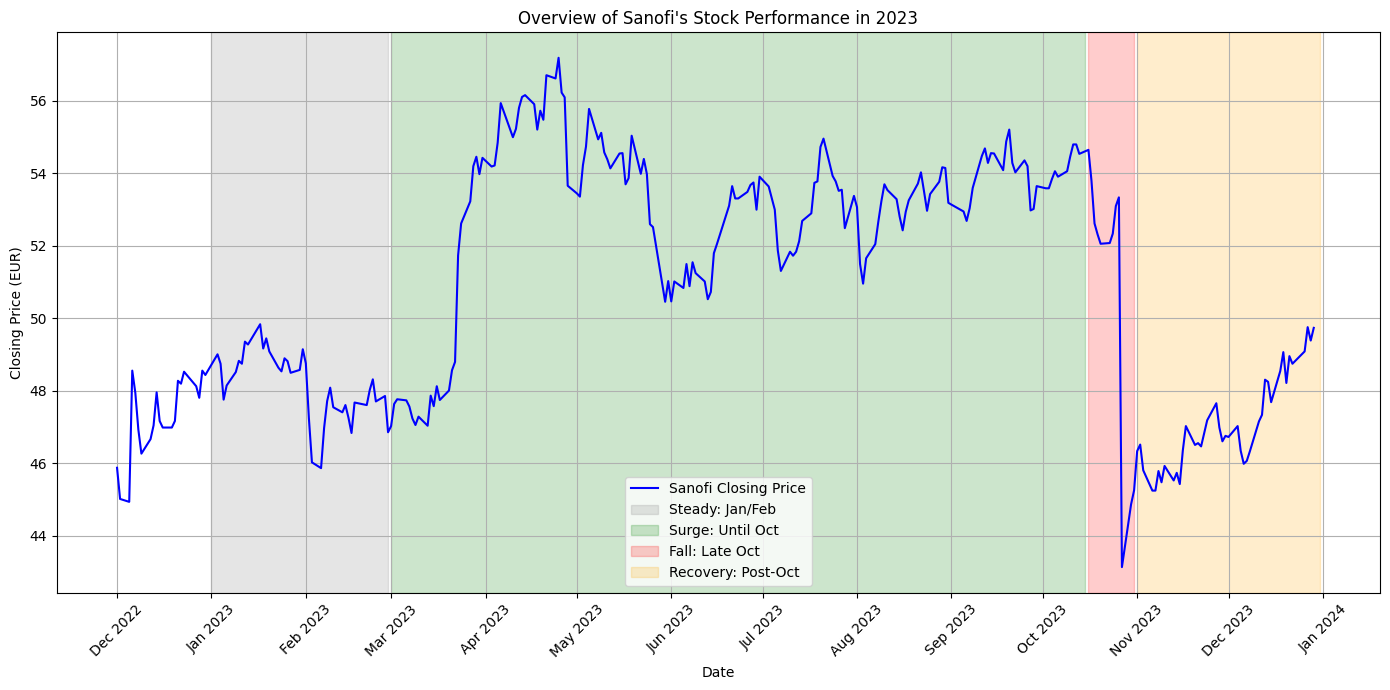

In [5]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(sanofi_data.index, sanofi_data['Close'], label='Sanofi Closing Price', color='blue')

# Highlight key periods
# Steady in Jan/Feb
plt.axvspan(datetime(2023, 1, 1), datetime(2023, 2, 28), color='grey', alpha=0.2, label='Steady: Jan/Feb')
# Surge until October
plt.axvspan(datetime(2023, 3, 1), datetime(2023, 10, 15), color='green', alpha=0.2, label='Surge: Until Oct')
# Fall in late October
plt.axvspan(datetime(2023, 10, 16), datetime(2023, 10, 31), color='red', alpha=0.2, label='Fall: Late Oct')
# Assuming the recovery to Q1 levels is visible in the data, we mark November and December
# Recovery to Q1 levels
plt.axvspan(datetime(2023, 11, 1), datetime(2023, 12, 31), color='orange', alpha=0.2, label='Recovery: Post-Oct')

# Customize the plot
plt.title('Overview of Sanofi\'s Stock Performance in 2023')
plt.xlabel('Date')
plt.ylabel('Closing Price (EUR)')
plt.legend()
plt.grid(True)

# Format the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


# OPTION 1: Significant Daily Returns Analysis

This method identifies days with significant stock price movements by comparing daily returns against a predetermined significance threshold. It's useful for spotting immediate market reactions to news events.

### Correlate News Events With Significant Returns

In [6]:
# Define a significance threshold for daily returns
return_significance_threshold = 2  # Example: 2%

In [7]:
# Filter days with significant returns
significant_returns = sanofi_data[abs(sanofi_data['DailyReturn']) >= return_significance_threshold].copy()
significant_returns['date'] = significant_returns.index.date

# Display the significant returns
significant_returns[['DailyReturn']].head()

,DailyReturn
Date,
2022-12-06,8.056975
2022-12-08,-2.127661
2022-12-21,2.353691
2023-01-05,-2.031189
2023-02-02,-3.097432


In [8]:
# Prepare to correlate news events with significant returns
significant_events_by_return = []

# Iterate over news events to find matches
for index, news in gdelt_data.iterrows():
    if news['date'] in significant_returns['date'].values:
        significant_events_by_return.append(news)

# Convert to DataFrame for easier handling
significant_events_by_return_df = pd.DataFrame(significant_events_by_return)

# Display significant news events correlated with returns
significant_events_by_return_df[['date', 'title', 'url']].head()

,date,title,url
241,2023-12-13,FTC cows Sanofi into giving up on Maze licensi...,https://www.mmm-online.com/home/channel/ftc-co...
242,2023-12-13,Myeloma : Isatuximab 4 - Drug Regimen Boosts M...,https://www.medscape.com/s/viewarticle/myeloma...
243,2023-12-13,Press Release : Statement on FTC challenge to ...,https://biztoc.com/x/76aee9d28f3d1f69
244,2023-12-13,Pfizer revamps cancer division with Seagen pur...,https://www.theday.com/state/20231212/pfizer-r...
245,2023-12-13,Doctors and Experts around the World Call for ...,http://www.businessghana.com/site/news/general...


In [9]:
len(significant_events_by_return_df)

975

In [10]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Convert NaN values to a string (e.g., empty string) and ensure all titles are strings
significant_events_by_return_df['title'] = significant_events_by_return_df['title'].fillna('').astype(str)

# Perform sentiment analysis on the titles and store the compound sentiment score
significant_events_by_return_df['Sentiment'] = significant_events_by_return_df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Calculate the absolute sentiment score for selection
significant_events_by_return_df['abs_sentiment'] = significant_events_by_return_df['Sentiment'].abs()

# Group by date and select the news item with the highest absolute sentiment score per date
most_significant_news_per_date_df = significant_events_by_return_df.loc[significant_events_by_return_df.groupby('date')['abs_sentiment'].idxmax()]


In [11]:
len(most_significant_news_per_date_df)

24

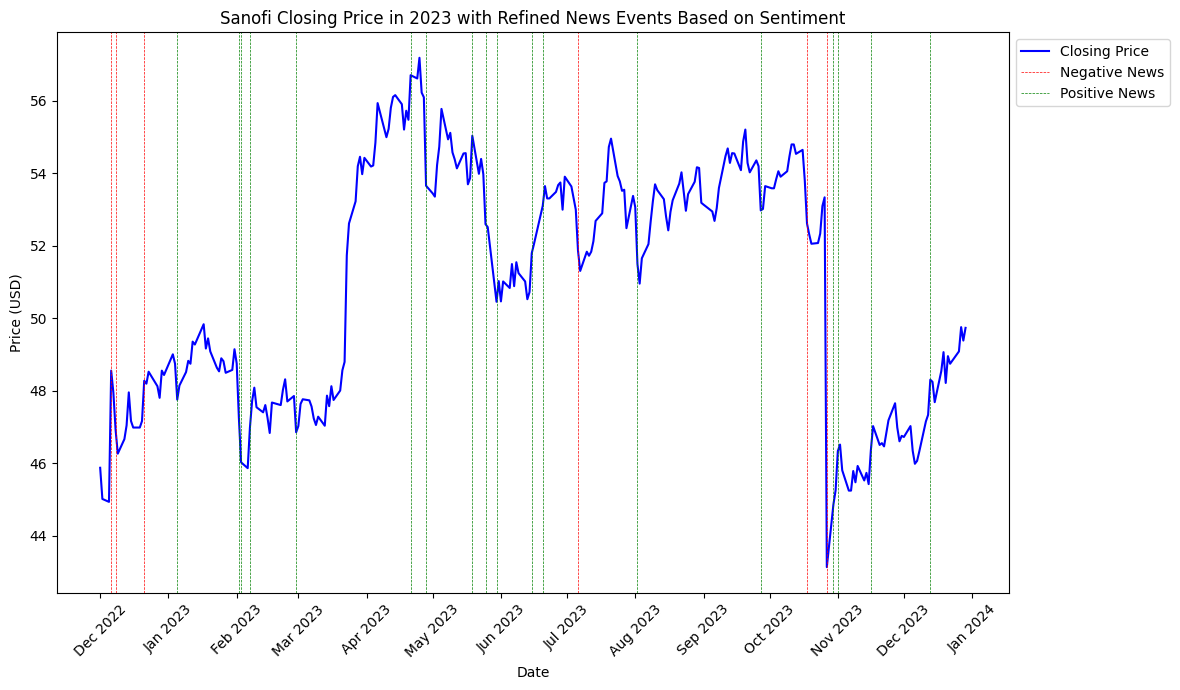

In [12]:
# Ensure 'date' is the correct datetime type if not already
most_significant_news_per_date_df['date'] = pd.to_datetime(most_significant_news_per_date_df['date'])

plt.figure(figsize=(14, 7))
plt.plot(sanofi_data.index, sanofi_data['Close'], label='Closing Price', color='blue')

# Flags to add legend labels only once
added_positive_label = False
added_negative_label = False

# Iterate through rows of the DataFrame to access both date and sentiment
for index, row in most_significant_news_per_date_df.iterrows():
    # Determine the color based on sentiment
    color = 'green' if row['Sentiment'] > 0 else 'red'
    label = None

    # Add label only for the first occurrence
    if color == 'green' and not added_positive_label:
        label = 'Positive News'
        added_positive_label = True
    elif color == 'red' and not added_negative_label:
        label = 'Negative News'
        added_negative_label = True

    plt.axvline(x=row['date'], color=color, linestyle='--', linewidth=0.5, label=label)

# Format the dates on the x-axis
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Customize the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Sanofi Closing Price in 2023 with Refined News Events Based on Sentiment')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend outside

plt.show()

In [13]:
# Iterate through the DataFrame and print date and title
for index, row in most_significant_news_per_date_df.iterrows():
    # Formatting date as YYYY-MM-DD and printing title next to it
    formatted_output = f"{row['date'].strftime('%Y-%m-%d')}: {row['title']}"
    print(formatted_output)

2022-12-06: Zantac Cases Tossed After Judge Rejects Cancer - Link Evidence
2022-12-08: Lung cancer therapeutics market size to grow by USD 10 , 204 . 33 million : High prevalence of lung cancer remains key growth driver
2022-12-21: Stocks lose 1 , 138 points as political crisis deepens - Newspaper
2023-01-05: Juno v . Kite : A Rare Opportunity for the Supreme Court to Grant Rehearing
2023-02-02: BlackRock Income and Growth Investment Trust strong performance from exposure to commodities and energy
2023-02-03: Press Release : Strong sales performance and double digit EPS growth marking the achievement of the 2022 profitability milestone
2023-02-07: How to support people with Graft - Versus - Host Disease
2023-02-28: Discovery Education and Social Impact Partners Offering Free STEM - Focused Resources to Educators and Students Celebrating Women History Month
2023-04-21: Global Big Pharma Partnering Financial Terms and Agreements Report 2023 : Comprehensive Review of Deal Trends , Key Pla

# OPTION 2: Abnormal Returns Analysis

This approach involves calculating abnormal returns as the difference between actual returns and expected (historically average) returns. It helps in identifying how specific news events deviate from normal market behavior, offering insights into their impact.

In [14]:
# Calculate the historical average return
historical_avg_return = sanofi_data['DailyReturn'].mean()

# Calculate abnormal returns
sanofi_data['AbnormalReturn'] = sanofi_data['DailyReturn'] - historical_avg_return

# Calculate the mean and standard deviation of abnormal returns
mean_abnormal_return = sanofi_data['AbnormalReturn'].mean()
std_abnormal_return = sanofi_data['AbnormalReturn'].std()

# Define a threshold for significant abnormal returns
threshold = mean_abnormal_return + std_abnormal_return

# Identify days with significant abnormal returns
significant_abnormal_returns = sanofi_data[sanofi_data['AbnormalReturn'] > threshold]

# Convert news event dates to datetime for comparison
gdelt_data['date'] = pd.to_datetime(gdelt_data['date'])

# Filter news events that match the significant abnormal return dates
matched_news_events = gdelt_data[gdelt_data['date'].isin(significant_abnormal_returns.index)]

In [15]:
len(matched_news_events)

595

In [16]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Convert NaN values to a string (e.g., empty string) and ensure all titles are strings
matched_news_events['title'] = matched_news_events['title'].fillna('').astype(str)

# Perform sentiment analysis on the titles and store the compound sentiment score
matched_news_events['Sentiment'] = matched_news_events['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Calculate the absolute sentiment score for selection
matched_news_events['abs_sentiment'] = matched_news_events['Sentiment'].abs()

# Group by date and select the news item with the highest absolute sentiment score per date
most_significant_matched_news_events_df = matched_news_events.loc[matched_news_events.groupby('date')['abs_sentiment'].idxmax()]

In [17]:
len(most_significant_matched_news_events_df)

15

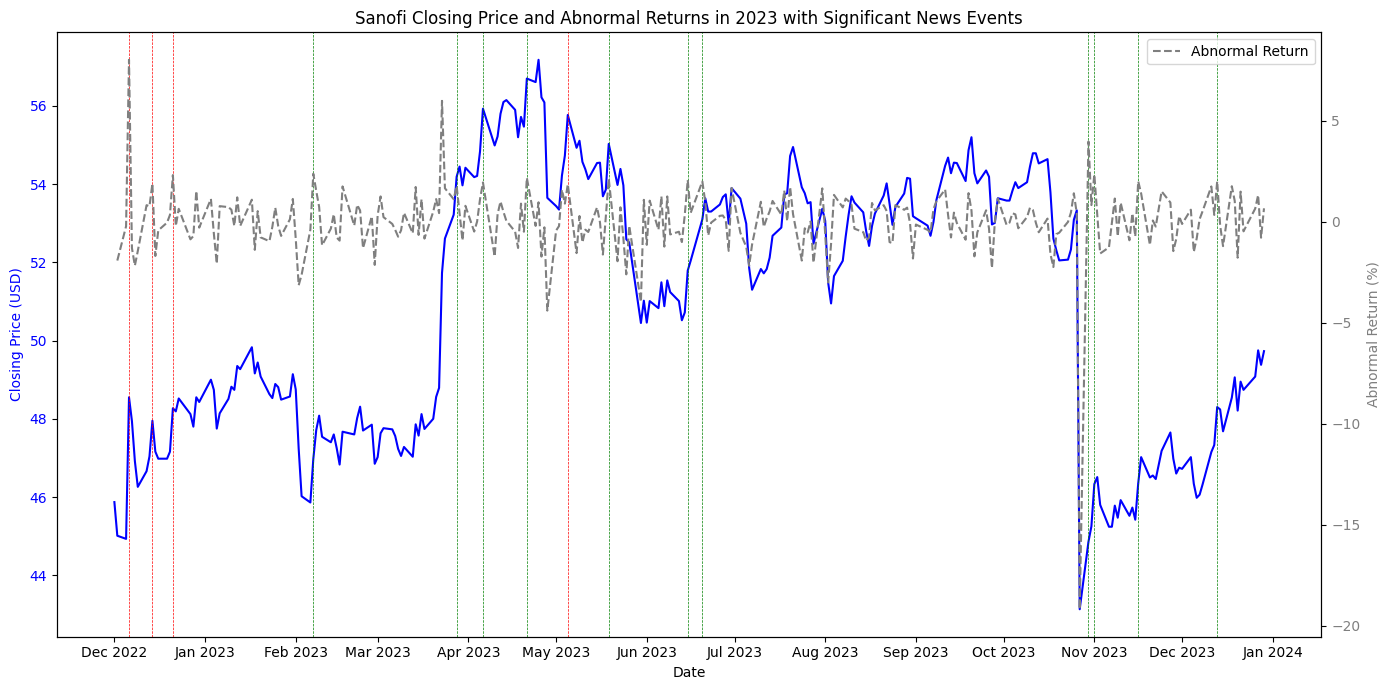

In [18]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting Sanofi's closing prices
color = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price (USD)', color=color)
ax1.plot(sanofi_data.index, sanofi_data['Close'], label='Closing Price', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Add a second y-axis for abnormal returns
ax2 = ax1.twinx()
color = 'tab:grey'
ax2.set_ylabel('Abnormal Return (%)', color=color)
ax2.plot(sanofi_data.index, sanofi_data['AbnormalReturn'], label='Abnormal Return', color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Highlight news events based on sentiment
for index, row in most_significant_matched_news_events_df.iterrows():
    color = 'green' if row['Sentiment'] > 0 else 'red'  # Green for positive, red for negative sentiment
    label = f"{'Positive' if row['Sentiment'] > 0 else 'Negative'} News Event" if (color == 'green' and not ax1.get_legend_handles_labels()[1].count('Positive News Event')) or (color == 'red' and not ax1.get_legend_handles_labels()[1].count('Negative News Event')) else ""
    ax1.axvline(x=row['date'], color=color, linestyle='--', linewidth=0.5, label=label)

# Format the dates on the x-axis
ax1.xaxis.set_major_formatter(DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Simplify the legend to avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.title('Sanofi Closing Price and Abnormal Returns in 2023 with Significant News Events')
plt.tight_layout()
plt.show()


In [19]:
# Iterate through the DataFrame and print date and title
for index, row in most_significant_matched_news_events_df.iterrows():
    # Formatting date as YYYY-MM-DD and printing title next to it
    formatted_output = f"{row['date'].strftime('%Y-%m-%d')}: {row['title']}"
    print(formatted_output)

2022-12-06: Zantac Cases Tossed After Judge Rejects Cancer - Link Evidence
2022-12-14: Alpha - 9 Theranostics Announces Oversubscribed $75 Million Series B Financing to Advance Portfolio of Radiopharmaceuticals for Cancer
2022-12-21: Stocks lose 1 , 138 points as political crisis deepens - Newspaper
2023-02-07: How to support people with Graft - Versus - Host Disease
2023-03-28: Sleeping Aids Market size to grow by USD 36 , 416 . 19 million from 2022 to 2027 , Driven by the growing patient - care services
2023-04-06: Global Opportunities Trust Plc - Portfolio Holdings as at 31 March 2023
2023-04-21: Global Big Pharma Partnering Financial Terms and Agreements Report 2023 : Comprehensive Review of Deal Trends , Key Players , and Top Deal Values
2023-05-05: Breast Cancer Screening Global Market Report 2023 : Sector to Reach $2 . 12 Billion by 2028 at a 5 . 2 % CAGR
2023-05-19: Pfizer Maternal RSV Vaccine First to Win FDA Panel Support
2023-06-15: Share Market Today LIVE | Sensex , Nifty ,

# Stock News Sentiment Analysis

https://towardsdatascience.com/stock-news-sentiment-analysis-with-python-193d4b4378d4

In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Assuming gdelt_data is already prepared
analyzer = SentimentIntensityAnalyzer()

# Ensure all titles are strings
gdelt_data['title'] = gdelt_data['title'].astype(str)

# Apply Sentiment Analysis on the 'title' column
gdelt_data['Sentiment'] = gdelt_data['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# For the surge period (March-April), consider both positive and highly impactful news
march_april_news = gdelt_data[(gdelt_data['date'] >= pd.to_datetime('2023-03-15')) &
                              (gdelt_data['date'] <= pd.to_datetime('2023-04-15'))]

# For the drop period (late October), consider news regardless of sentiment, aiming for the most impactful (by absolute sentiment)
late_october_news = gdelt_data[(gdelt_data['date'] >= pd.to_datetime('2023-10-15')) &
                               (gdelt_data['date'] <= pd.to_datetime('2023-10-31'))]

# Selecting the most impactful news by absolute sentiment for each period
march_april_news['abs_sentiment'] = march_april_news['Sentiment'].abs()
late_october_news['abs_sentiment'] = late_october_news['Sentiment'].abs()

most_impactful_march_april_news = march_april_news.loc[march_april_news.groupby('date')['abs_sentiment'].idxmax()]
most_impactful_late_october_news = late_october_news.loc[late_october_news.groupby('date')['abs_sentiment'].idxmax()]

# Ensure the DataFrames are sorted by date
most_impactful_march_april_news = most_impactful_march_april_news.sort_values(by='date')
most_impactful_late_october_news = most_impactful_late_october_news.sort_values(by='date')

# Displaying impactful news for March-April
print("Impactful News for March-April Surge:")
display(most_impactful_march_april_news[['date', 'title', 'Sentiment']])

# Displaying impactful news for Late October
print("\nImpactful News for Late October Drop:")
display(most_impactful_late_october_news[['date', 'title', 'Sentiment']])


Impactful News for March-April Surge:


,date,title,Sentiment
6348,2023-03-15,Hand Eczema ( HE ) Treatment Market is expecte...,0.6808
6286,2023-03-16,Worldwide Latent TB Diagnostics Industry to 20...,0.7845
6234,2023-03-17,"Ranitidine Market Size , Share , Trends , Grow...",0.6705
6113,2023-03-18,Stocks and yields hit on banking crisis woes a...,-0.7906
6011,2023-03-19,"Delgocitinib safe , efficacious in chronic han...",0.7269
5970,2023-03-20,Techdow united states Announces FDA Approval o...,0.8481
5910,2023-03-21,2023 PM Society Awards – Winners Announced,0.7269
5883,2023-03-22,NY Times Deceives about the Odds of Dying from...,-0.3818
5872,2023-03-24,Shortage of key heart medication nitroglycerin...,-0.5994
5852,2023-03-25,2023 PM Society Awards – Winners Announced,0.7269



Impactful News for Late October Drop:


,date,title,Sentiment
1354,2023-10-15,Regeneron to Showcase Progress from Innovative...,0.7096
1348,2023-10-16,CAFC Finds No Violation of IPR Reply Restricti...,-0.7964
1332,2023-10-17,Sialolithiasis Treatment Market to Observe Pro...,0.5994
1321,2023-10-18,Oral Cancer Treatment Market Expected to Reach...,-0.6486
1301,2023-10-19,Anna Fawcett on the ground at LIA inspirationa...,0.8442
1273,2023-10-20,ESMO presentations highlight advances in kidne...,-0.8126
1264,2023-10-21,"Merck : MS drug effective , has Blockbuster P...",0.7906
1255,2023-10-22,"Key events next week : IPO launches , Q2 earni...",0.4588
1251,2023-10-23,BioNTech Presents Positive Phase 1 / 2 Data Up...,0.7351
1222,2023-10-24,Preventive care decline in popularity,0.7430


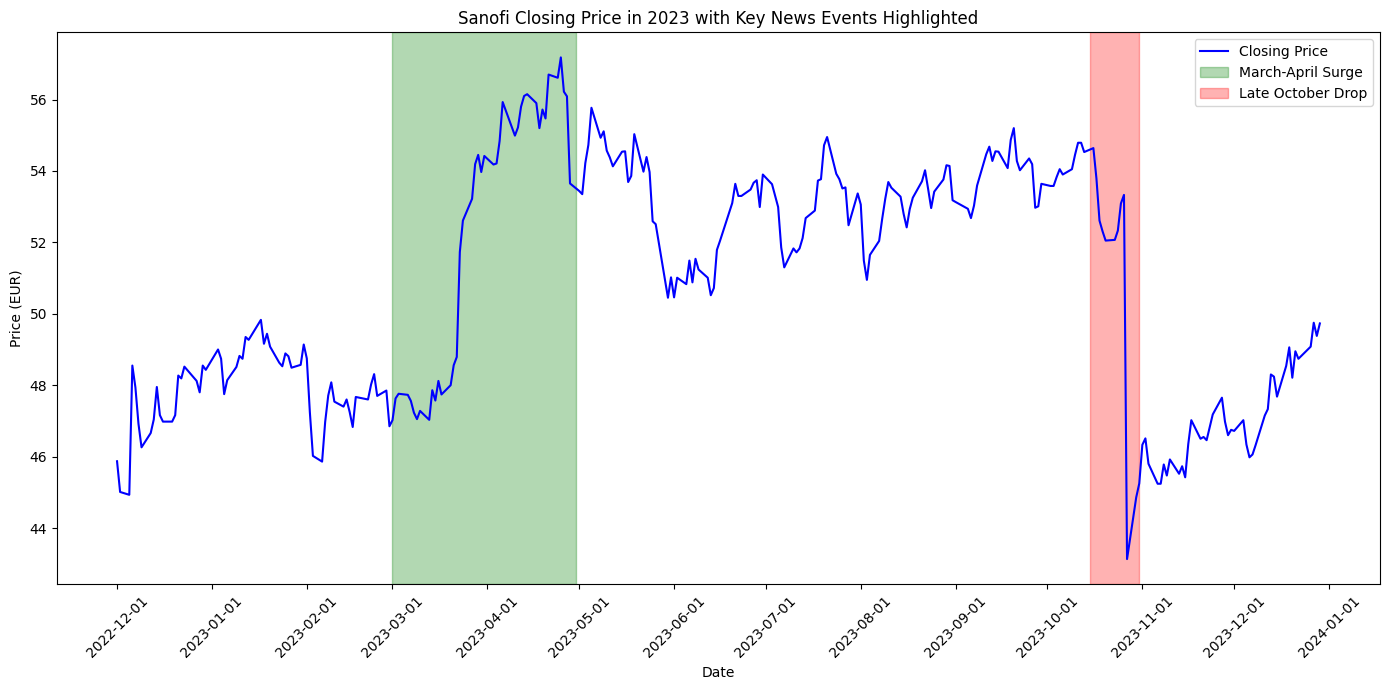

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(sanofi_data.index, sanofi_data['Close'], label='Closing Price', color='blue')

# Highlight the March-April surge period
plt.axvspan('2023-03-01', '2023-04-30', color='green', alpha=0.3, label='March-April Surge')

# Highlight the late October drop period
plt.axvspan('2023-10-15', '2023-10-31', color='red', alpha=0.3, label='Late October Drop')

# Customize the plot
plt.legend()
plt.title('Sanofi Closing Price in 2023 with Key News Events Highlighted')
plt.xlabel('Date')
plt.ylabel('Price (EUR)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()
plt.show()


In [22]:
# Select the top 3 positive news for March-April
top_3_march_april_news = march_april_news.nlargest(3, 'Sentiment')

# Select the top 3 negative news for late October
top_3_late_october_news = late_october_news.nsmallest(3, 'Sentiment')

In [23]:
# Print top 3 news for March-April Surge
print("Top 3 News for March-April Surge:")
for index, news in top_3_march_april_news.iterrows():
    print(f"Date: {news['date'].strftime('%Y-%m-%d')}, Sentiment: {news['Sentiment']}, \n Title: {news['title']}")

print("\nTop 3 News for Late October Drop:")
for index, news in top_3_late_october_news.iterrows():
    print(f"Date: {news['date'].strftime('%Y-%m-%d')}, Sentiment: {news['Sentiment']}, \n Title: {news['title']}")


Top 3 News for March-April Surge:
Date: 2023-03-20, Sentiment: 0.8481, 
 Title: Techdow united states Announces FDA Approval of Generic Lovenox® , ( Enoxaparin Sodium – Preservative Free ) In Prefilled Syringes
Date: 2023-03-20, Sentiment: 0.8481, 
 Title: Techdow united states Announces FDA Approval of Generic Lovenox® , ( Enoxaparin Sodium – Preservative Free ) In Prefilled Syringes
Date: 2023-03-16, Sentiment: 0.7845, 
 Title: Worldwide Latent TB Diagnostics Industry to 2027 : Increasing Diagnostic Options and Increased Health Care Spending Drives Growth

Top 3 News for Late October Drop:
Date: 2023-10-27, Sentiment: -0.8519, 
 Title: Investors deliver harshest punishment for earnings warnings in 16 years
Date: 2023-10-20, Sentiment: -0.8126, 
 Title: ESMO presentations highlight advances in kidney cancer , melanoma , lung cancer
Date: 2023-10-16, Sentiment: -0.7964, 
 Title: CAFC Finds No Violation of IPR Reply Restrictions in Apple Expansion of Analogous Art Arguments


## Word Cloud

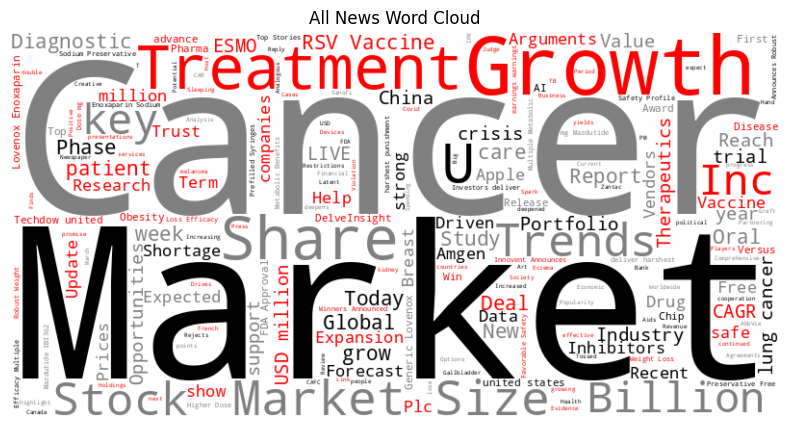

In [28]:
# Assuming 'gdelt_data' contains all the news titles
all_titles = pd.concat([
    top_3_march_april_news,
    top_3_late_october_news,
    most_impactful_march_april_news,
    most_impactful_late_october_news,
    most_significant_matched_news_events_df,
    most_significant_news_per_date_df
])['title']

# Generate text for the WordCloud
all_text = ' '.join(all_titles)

# Define the custom color function as before
def accuracy_colors(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['gray', 'red', 'black']  # Define your color palette here
    return colors[random_state.randint(0, len(colors)-1)]

# Create and display the WordCloud for all news
all_news_wordcloud = WordCloud(width=800, height=400, background_color='white',
                               color_func=accuracy_colors,  # Use the custom color function
                               stopwords=STOPWORDS).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(all_news_wordcloud, interpolation='bilinear')
plt.title('All News Word Cloud')
plt.axis('off')
plt.show()


In [24]:
# Concatenate all titles based on sentiment polarity
positive_titles = pd.concat([df[df['Sentiment'] > 0]['title'] for df in [
    top_3_march_april_news,
    top_3_late_october_news,
    most_impactful_march_april_news,
    most_impactful_late_october_news,
    most_significant_matched_news_events_df,
    most_significant_news_per_date_df
]])

negative_titles = pd.concat([df[df['Sentiment'] < 0]['title'] for df in [
    top_3_march_april_news,
    top_3_late_october_news,
    most_impactful_march_april_news,
    most_impactful_late_october_news,
    most_significant_matched_news_events_df,
    most_significant_news_per_date_df
]])

In [25]:
# Generate text for WordClouds
positive_text = ' '.join(positive_titles)
negative_text = ' '.join(negative_titles)

In [26]:
# Define a custom color function
def accuracy_colors(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['gray', 'red', 'black']  # Define your color palette here
    return colors[random_state.randint(0, len(colors)-1)]

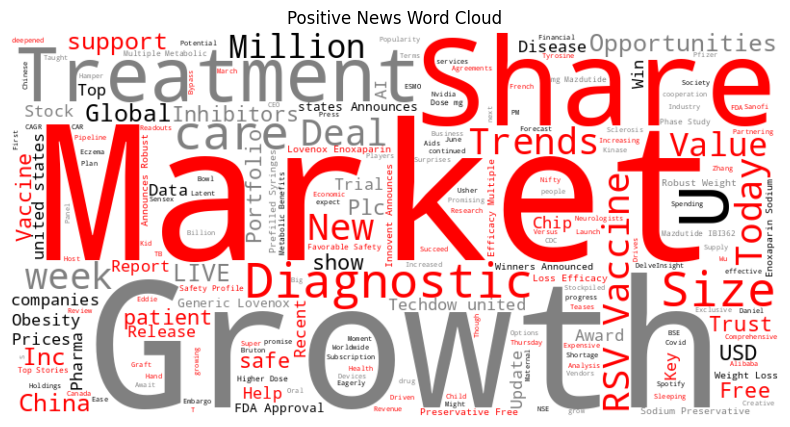

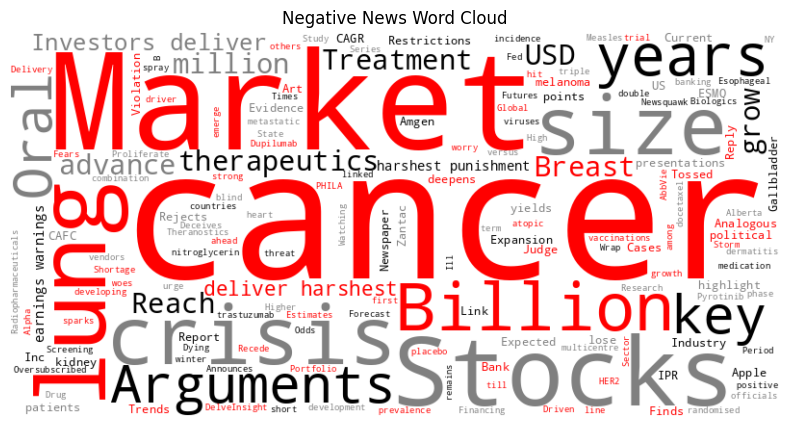

In [27]:
# Generate and display the WordCloud for Positive News
positive_wordcloud = WordCloud(width=800, height=400, background_color='white',
                               color_func=accuracy_colors,  # Use the custom color function
                               stopwords=STOPWORDS).generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive News Word Cloud')
plt.axis('off')
plt.show()

# Generate and display the WordCloud for Negative News
negative_wordcloud = WordCloud(width=800, height=400, background_color='white',
                               color_func=accuracy_colors,  # Use the custom color function
                               stopwords=STOPWORDS).generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative News Word Cloud')
plt.axis('off')
plt.show()


In conducting a comprehensive analysis of Sanofi's stock performance throughout 2023, we employed a multifaceted approach, integrating quantitative stock data analysis with qualitative news sentiment evaluation to offer a holistic view of the factors driving stock price fluctuations. This analysis hinged on three primary techniques:

Significant Daily Returns Analysis: We commenced by identifying days with substantial stock price movements, defining a significance threshold for daily returns at 2%. This method allowed us to pinpoint days where Sanofi's stock exhibited notable deviations from its usual trading pattern, likely in response to impactful events or announcements. By correlating these significant movements with corresponding dates from a curated GDELT news dataset, we were able to directly link stock price fluctuations to specific news stories, highlighting the immediate market reactions to new information.

Abnormal Returns Analysis: Further, we delved into calculating abnormal returns, representing the difference between actual returns and the expected baseline performance, based on historical averages. This approach illuminated how specific events caused deviations from normal market behavior, offering insights into the unique impact of news stories on Sanofi's stock. Analyzing abnormal returns helped isolate instances where external factors led to significant market reactions, beyond what could be attributed to the market's general trends.

Stock News Sentiment Analysis: Complementing the quantitative analyses, we applied sentiment analysis to news headlines using the VADER SentimentIntensityAnalyzer. This technique quantified the emotional valence of news coverage, distinguishing between positively and negatively framed stories. By identifying news items with extreme positive or negative sentiments, we could assess their potential influence on stock price movements. This analysis was pivotal in understanding the broader narrative context around Sanofi's stock, revealing how investor perceptions and sentiment, shaped by news media, contributed to the stock's performance dynamics over the year.

Through the integration of significant daily returns analysis, abnormal returns computation, and news sentiment evaluation, we gained a nuanced understanding of the interplay between news events and stock market behavior. This comprehensive approach enabled us to not only trace the timeline of Sanofi's stock performance but also to interpret the underlying causes behind its pivotal moments in 2023. The insights derived from this analysis are instrumental for investors, analysts, and the company itself, providing a data-driven basis for strategic decision-making and future outlook considerations.

